In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-08 02:48:27.580802: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-08 02:48:28.986335: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-08 02:48:29.028359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-08 02:48:29.028408: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-08 02:48:29.043255: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-08 02:48:29.043325: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-08 02:48:29.050493: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

ukdale_gen_GASF_60m_300S0X_R42_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.7055908662900189, 1: 0.49534787638406874, 2: 1.3009331597222222, 3: 0.9557266755946687, 4: 1.19482978553775, 5: 1.6470766018243763, 6: 0.9269963505907095, 7: 1.3009331597222222, 8: 0.9261370658756644, 9: 3.0130176919983915, 10: 0.7942103868574457, 11: 1.2711407972858355}
 
Tests 
HEKA test: 1770 train: 7080
fridge/freezer test: 2522 train: 10085
HTPC test: 960 train: 3840
boiler test: 1307 train: 5227
computer monitor test: 1045 train: 4181
desktop computer test: 758 train: 3033
laptop computer test: 1347 train: 5389
light test: 960 train: 3840
microwave test: 1348 train: 5394
server computer test: 415 train: 1658
television test: 1572 train: 6290
washer dryer test: 983 train: 3930


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/ukdale/TL/ukdale_42_refit, iawe, eco, redd_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data ukdale training on model refit seed 42
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.7055908662900189, 1: 0.49534787638406874, 2: 1.3009331597222222, 3: 0.9557266755946687, 4: 1.19482978553775, 5: 1.6470766018243763, 6: 0.9269963505907095, 7: 1.3009331597222222, 8: 0.9261370658756644, 9: 3.0130176919983915, 10: 0.7942103868574457, 11: 1.2711407972858355}
 
Tests 
HEKA test: 1770 train: 7080
fridge/freezer test: 2522 train: 10085
HTPC test: 960 train: 3840
boiler test: 1307 train: 5227
computer monitor test: 1045 train: 4181
desktop computer test: 758 train: 3033
laptop computer test: 1347 train: 5389
light test: 960 train: 3840
microwave test: 1348 train: 5394
server computer test: 415 train: 1658
television test: 1572 train: 6290
washer dryer test: 983 train: 3930
loading model
compling TL model..


2022-02-08 02:48:41.590809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-08 02:48:41.591317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-08 02:48:41.593867: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-08 02:48:42.467440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-08 02:48:42.467474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-08 02:48:42.467487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-08 02:48:42.468340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-08 02:48:43.058225: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-08 02:48:43.076519: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/20


2022-02-08 02:48:43.565200: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-08 02:48:44.298082: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-08 02:48:45.186081: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-08 02:48:45.982228: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1874/1874 - 96s - loss: 1.2009 - accuracy: 0.6023
Epoch 2/20
1874/1874 - 93s - loss: 0.9111 - accuracy: 0.6992
Epoch 3/20
1874/1874 - 93s - loss: 0.8124 - accuracy: 0.7313
Epoch 4/20
1874/1874 - 93s - loss: 0.7530 - accuracy: 0.7516
Epoch 5/20
1874/1874 - 93s - loss: 0.7231 - accuracy: 0.7604
Epoch 6/20
1874/1874 - 92s - loss: 0.6898 - accuracy: 0.7731
Epoch 7/20
1874/1874 - 92s - loss: 0.6675 - accuracy: 0.7814
Epoch 8/20
1874/1874 - 92s - loss: 0.6412 - accuracy: 0.7884
Epoch 9/20
1874/1874 - 92s - loss: 0.6252 - accuracy: 0.7936
Epoch 10/20
1874/1874 - 92s - loss: 0.6079 - accuracy: 0.7975
Epoch 11/20
1874/1874 - 92s - loss: 0.5940 - accuracy: 0.8021
Epoch 12/20
1874/1874 - 92s - loss: 0.5779 - accuracy: 0.8083
Epoch 13/20
1874/1874 - 92s - loss: 0.5704 - accuracy: 0.8110
Epoch 14/20
1874/1874 - 92s - loss: 0.5539 - accuracy: 0.8165
Epoch 15/20
1874/1874 - 92s - loss: 0.5457 - accuracy: 0.8190
Epoch 16/20
1874/1874 - 92s - loss: 0.5422 - accuracy: 0.8222
Epoch 17/20
1874/1874 - 92s 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 96s - loss: 2.3215 - accuracy: 0.2189
Epoch 2/20
1874/1874 - 92s - loss: 2.0221 - accuracy: 0.2976
Epoch 3/20
1874/1874 - 92s - loss: 1.7621 - accuracy: 0.3986
Epoch 4/20
1874/1874 - 92s - loss: 1.5406 - accuracy: 0.4579
Epoch 5/20
1874/1874 - 92s - loss: 1.4696 - accuracy: 0.4798
Epoch 6/20
1874/1874 - 92s - loss: 1.4122 - accuracy: 0.4983
Epoch 7/20
1874/1874 - 92s - loss: 1.3775 - accuracy: 0.5105
Epoch 8/20
1874/1874 - 92s - loss: 1.3567 - accuracy: 0.5202
Epoch 9/20
1874/1874 - 92s - loss: 1.3359 - accuracy: 0.5220
Epoch 10/20
1874/1874 - 92s - loss: 1.3324 - accuracy: 0.5244
Epoch 11/20
1874/1874 - 92s - loss: 1.3041 - accuracy: 0.5251
Epoch 12/20
1874/1874 - 93s - loss: 1.2825 - accuracy: 0.5330
Epoch 13/20
1874/1874 - 93s - loss: 1.2656 - accuracy: 0.5335
Epoch 14/20
1874/1874 - 93s - loss: 1.2523 - accuracy: 0.5565
Epoch 15/20
1874/1874 - 93s - loss: 1.2518 - accuracy: 0.5639
Epoch 16/20
1874/1874 - 92s - loss: 1.2126 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 96s - loss: 1.9827 - accuracy: 0.3566
Epoch 2/20
1874/1874 - 92s - loss: 1.5383 - accuracy: 0.5014
Epoch 3/20
1874/1874 - 92s - loss: 1.3637 - accuracy: 0.5554
Epoch 4/20
1874/1874 - 93s - loss: 1.2650 - accuracy: 0.5854
Epoch 5/20
1874/1874 - 92s - loss: 1.2248 - accuracy: 0.5993
Epoch 6/20
1874/1874 - 92s - loss: 1.1744 - accuracy: 0.6177
Epoch 7/20
1874/1874 - 92s - loss: 1.1382 - accuracy: 0.6278
Epoch 8/20
1874/1874 - 92s - loss: 1.1102 - accuracy: 0.6376
Epoch 9/20
1874/1874 - 91s - loss: 1.0849 - accuracy: 0.6459
Epoch 10/20
1874/1874 - 92s - loss: 1.0678 - accuracy: 0.6527
Epoch 11/20
1874/1874 - 92s - loss: 1.0394 - accuracy: 0.6628
Epoch 12/20
1874/1874 - 92s - loss: 1.0283 - accuracy: 0.6660
Epoch 13/20
1874/1874 - 92s - loss: 1.0032 - accuracy: 0.6728
Epoch 14/20
1874/1874 - 92s - loss: 0.9825 - accuracy: 0.6810
Epoch 15/20
1874/1874 - 92s - loss: 0.9672 - accuracy: 0.6854
Epoch 16/20
1874/1874 - 92s - loss: 0.9480 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 96s - loss: 1.8680 - accuracy: 0.4177
Epoch 2/20
1874/1874 - 94s - loss: 1.4135 - accuracy: 0.5409
Epoch 3/20
1874/1874 - 93s - loss: 1.3150 - accuracy: 0.5726
Epoch 4/20
1874/1874 - 93s - loss: 1.2361 - accuracy: 0.5896
Epoch 5/20
1874/1874 - 93s - loss: 1.2016 - accuracy: 0.6042
Epoch 6/20
1874/1874 - 93s - loss: 1.1656 - accuracy: 0.6159
Epoch 7/20
1874/1874 - 94s - loss: 1.1271 - accuracy: 0.6296
Epoch 8/20
1874/1874 - 94s - loss: 1.1184 - accuracy: 0.6361
Epoch 9/20
1874/1874 - 94s - loss: 1.0933 - accuracy: 0.6421
Epoch 10/20
1874/1874 - 94s - loss: 1.0642 - accuracy: 0.6494
Epoch 11/20
1874/1874 - 93s - loss: 1.0872 - accuracy: 0.6462
Epoch 12/20
1874/1874 - 93s - loss: 1.0381 - accuracy: 0.6598
Epoch 13/20
1874/1874 - 94s - loss: 1.0350 - accuracy: 0.6661
Epoch 14/20
1874/1874 - 93s - loss: 1.0298 - accuracy: 0.6664
Epoch 15/20
1874/1874 - 93s - loss: 1.0046 - accuracy: 0.6731
Epoch 16/20
1874/1874 - 94s - loss: 1.0065 - a

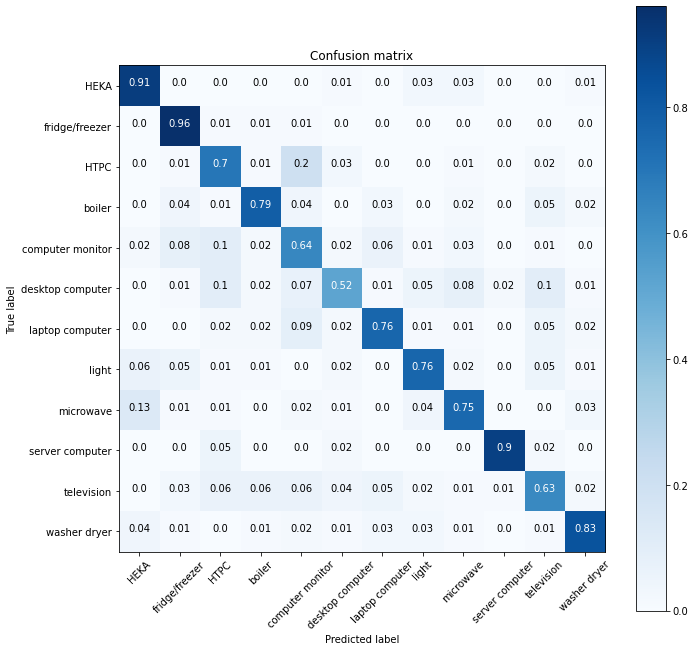

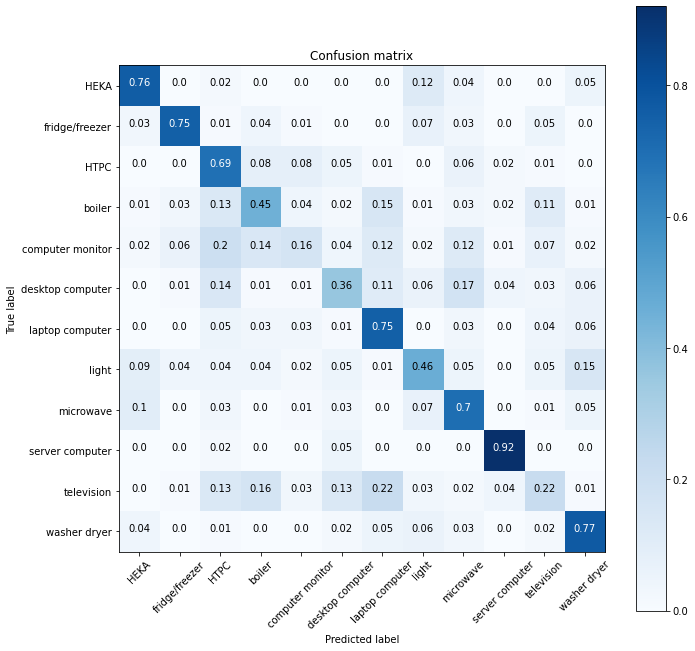

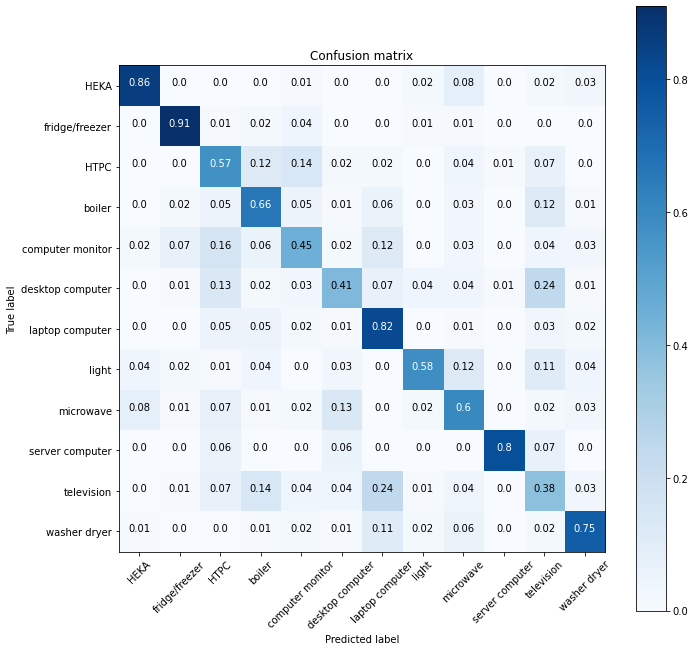

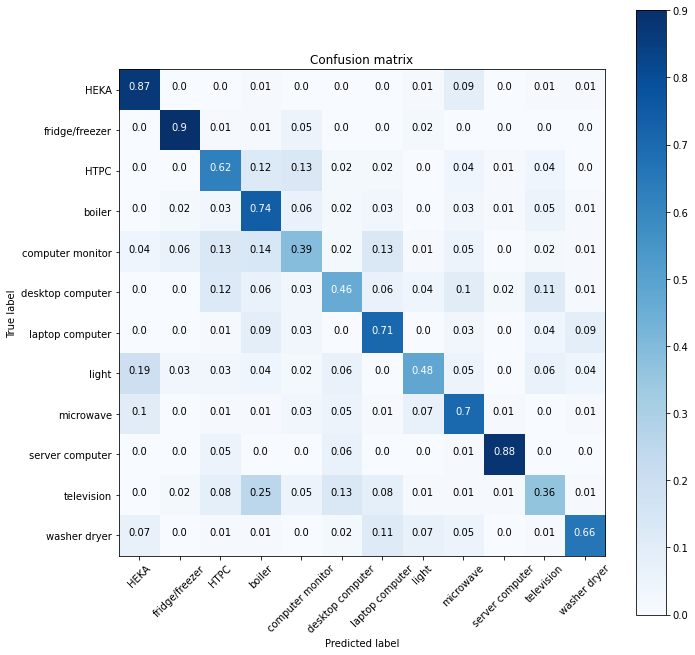

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()